Experimenting with estimating the gender of mailing list participants.

In [15]:
%matplotlib inline

Import the BigBang modules as needed. These should be in your Python environment if you've installed BigBang correctly.

In [2]:
import bigbang.mailman as mailman
import bigbang.graph as graph
import bigbang.process as process
from bigbang.parse import get_date
from bigbang.archive import Archive
reload(process)

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import pytz
import pickle
import os

from bigbang import parse
from gender_detector import GenderDetector

pd.options.display.mpl_style = 'default' # pandas has a set of preferred graph formatting options

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


Now let's load the data for analysis.

In [3]:
urls = ["https://lists.w3.org/Archives/Public/w3c-wai-gl",
"https://lists.w3.org/Archives/Public/public-apa",
"https://lists.w3.org/Archives/Public/public-aria-admin",
"https://lists.w3.org/Archives/Public/public-audio",
"https://lists.w3.org/Archives/Public/public-automotive",
"https://lists.w3.org/Archives/Public/public-browser-tools-testing/",
"https://lists.w3.org/Archives/Public/www-style/",
"https://lists.w3.org/Archives/Public/public-dxwg-wg",
"https://lists.w3.org/Archives/Public/public-device-apis",
"https://lists.w3.org/Archives/Public/w3c-wai-eo/",
"https://lists.w3.org/Archives/Public/public-exi",
"https://lists.w3.org/Archives/Public/public-html-media",
"https://lists.w3.org/Archives/Public/public-i18n-core",
"https://lists.w3.org/Archives/Public/public-poe-wg",
"https://lists.w3.org/Archives/Public/public-pointer-events",
"https://lists.w3.org/Archives/Public/public-data-shapes-wg",
"https://lists.w3.org/Archives/Public/public-secondscreen",
"https://lists.w3.org/Archives/Public/public-socialweb",
"https://lists.w3.org/Archives/Public/public-sdw-wg",
"https://lists.w3.org/Archives/Public/public-svg-wg",
"https://lists.w3.org/Archives/Public/public-tt",
"https://lists.w3.org/Archives/Public/public-tracking",
"https://lists.w3.org/Archives/Public/public-vc-wg",
"https://lists.w3.org/Archives/Public/public-webappsec",
"https://lists.w3.org/Archives/Public/public-webauthn",
"https://lists.w3.org/Archives/Public/public-wot-wg",
"https://lists.w3.org/Archives/Public/public-payments-wg",
"https://lists.w3.org/Archives/Public/public-web-perf",
"https://lists.w3.org/Archives/Public/public-webapps",
"https://lists.w3.org/Archives/Public/public-webrtc",
"https://lists.w3.org/Archives/Public/public-webfonts-wg",
"https://lists.w3.org/Archives/Public/public-xsl-query",
"https://lists.w3.org/Archives/Public/public-xsl-wg",
"https://lists.w3.org/Archives/Public/public-digipub-ig",
"https://lists.w3.org/Archives/Public/public-html-ig-zh",
"https://lists.w3.org/Archives/Public/www-international/",
"https://lists.w3.org/Archives/Public/public-i18n-its-ig/",
"https://lists.w3.org/Archives/Public/public-privacy/",
"https://lists.w3.org/Archives/Public/public-semweb-lifesci/",
"https://lists.w3.org/Archives/Public/w3c-wai-ig/",
"https://lists.w3.org/Archives/Public/public-web-and-tv",
#"https://lists.w3.org/Archives/Public/public-wot-ig", # no archives currently
"https://lists.w3.org/Archives/Public/public-webpayments-ig",
"https://lists.w3.org/Archives/Public/public-web-security"]
#mlists = [(url, mailman.open_list_archives(url,"../archives")) for url in urls[:5]]
mlists = [(url, mailman.open_list_archives(url,"../../w3c-archives")) for url in urls]

Opening 80 archive files
Date parsing error on: 
Thu, 3 Jul 2003 04:55:30 0200 
Opening 18 archive files
Opening 16 archive files
Opening 26 archive files
Opening 29 archive files
Opening 23 archive files
Opening 55 archive files
Opening 2 archive files
Opening 101 archive files
Opening 38 archive files
Opening 95 archive files
Opening 52 archive files
Opening 50 archive files
Opening 17 archive files
Opening 20 archive files
Opening 33 archive files
Opening 18 archive files
Opening 39 archive files
Opening 30 archive files
Opening 36 archive files
Opening 140 archive files
Opening 70 archive files
Opening 3 archive files
Opening 69 archive files
Opening 17 archive files
Opening 7 archive files
Opening 21 archive files
Opening 85 archive files
Opening 14 archive files
Opening 75 archive files
Opening 1 archive files
Opening 21 archive files
Opening 17 archive files
Opening 49 archive files
Opening 80 archive files
Opening 85 archive files
Opening 91 archive files
Opening 17 archive fil

For each of our lists, we'll clean up the names, find the first name if there is one, and guess its gender. Pandas groups the data together for comparison. We keep count of the names we find that are ambiguous, for the next step.

In [42]:
detector = GenderDetector('us')

gender_ambiguous_names = {}

def guess_gender(name):
    if not name:
        return 'name unknown'
    try:
        if detector.guess(name) == 'unknown':
            if name in gender_ambiguous_names:
                gender_ambiguous_names[name] += 1
            else:
                gender_ambiguous_names[name] = 1
        
        return detector.guess(name)
    except:
        return 'error'

def ml_shortname(url):
    return url.rstrip("/").split("/")[-1]

frames = []
for (url, ml) in mlists:
    activity = Archive.get_activity(Archive(ml)).sum(0)
    activityFrame = pd.DataFrame(activity, columns=['Message Count'])
    
    activityFrame['Name'] = activityFrame.index.map(lambda x: parse.clean_from(x))    
    activityFrame['First Name'] = activityFrame['Name'].map(lambda x: parse.guess_first_name(x))
    activityFrame['Guessed Gender'] = activityFrame['First Name'].map(guess_gender)
    
    activityFrame.to_csv(('senders_guessed_gender-%s.csv' % ml_shortname(url)),encoding='utf-8')
    frames.append((url, activityFrame))

In [43]:
series = []  

for (url, activityFrame) in frames:
    counts = activityFrame.groupby('Guessed Gender')['Message Count'].sum()
    participants = activityFrame.groupby('Guessed Gender')['Name'].count()
    
    counts_combined = pd.concat([counts, participants], keys=['message count', 'participants'])
    
    counts_combined.name=url
    series.append(counts_combined)

pd.DataFrame(series)

message count          \
Guessed Gender                                             error  female   
https://lists.w3.org/Archives/Public/w3c-wai-gl             28.0  5522.0   
https://lists.w3.org/Archives/Public/public-apa              3.0   243.0   
https://lists.w3.org/Archives/Public/public-ari...           NaN    37.0   
https://lists.w3.org/Archives/Public/public-audio            NaN    12.0   
https://lists.w3.org/Archives/Public/public-aut...           NaN    14.0   
https://lists.w3.org/Archives/Public/public-bro...           NaN    22.0   
https://lists.w3.org/Archives/Public/www-style/             61.0   272.0   
https://lists.w3.org/Archives/Public/public-dxw...           NaN    27.0   
https://lists.w3.org/Archives/Public/public-dev...          18.0   176.0   
https://lists.w3.org/Archives/Public/w3c-wai-eo/             NaN   300.0   
https://lists.w3.org/Archives/Public/public-exi              NaN    13.0   
https://lists.w3.org/Archives/Public/public-htm...           2.0    47.0   
https://lists.w3.org/Archives/Public/public-i18...           2.0   103.0   
https://lists.w3.org/Archives/Public/public-poe-wg           NaN    35.0   
https://lists.w3.org/Archives/Public/public-poi...           NaN    16.0   
https://lists.w3.org/Archives/Public/public-dat...           NaN   882.0   
https://lists.w3.org/Archives/Public/public-sec...           NaN     1.0   
https://lists.w3.org/Archives/Public/public-soc...           NaN   201.0   
https://lists.w3.org/Archives/Public/public-sdw-wg           NaN    10.0   
https://lists.w3.org/Archives/Public/public-svg-wg           NaN    18.0   
https://lists.w3.org/Archives/Public/public-tt               1.0   191.0   
https://lists.w3.org/Archives/Public/public-tra...           2.0   511.0   
https://lists.w3.org/Archives/Public/public-vc-wg            NaN     2.0   
https://lists.w3.org/Archives/Public/public-web...          18.0   869.0   
https://lists.w3.org/Archives/Public/public-web...         803.0    35.0   
https://lists.w3.org/Archives/Public/public-wot-wg           NaN     1.0   
https://lists.w3.org/Archives/Public/public-pay...           NaN    20.0   
https://lists.w3.org/Archives/Public/public-web...           1.0    90.0   
https://lists.w3.org/Archives/Public/public-web...          22.0   546.0   
https://lists.w3.org/Archives/Public/public-webrtc           NaN   153.0   
https://lists.w3.org/Archives/Public/public-web...           NaN     NaN   
https://lists.w3.org/Archives/Public/public-xsl...           NaN     8.0   
https://lists.w3.org/Archives/Public/public-xsl-wg           NaN    12.0   
https://lists.w3.org/Archives/Public/public-dig...           1.0   231.0   
https://lists.w3.org/Archives/Public/public-htm...          39.0     7.0   
https://lists.w3.org/Archives/Public/www-intern...          10.0   366.0   
https://lists.w3.org/Archives/Public/public-i18...           NaN     9.0   
https://lists.w3.org/Archives/Public/public-pri...           1.0   224.0   
https://lists.w3.org/Archives/Public/public-sem...           1.0  1297.0   
https://lists.w3.org/Archives/Public/w3c-wai-ig/             NaN   719.0   
https://lists.w3.org/Archives/Public/public-web...           NaN     NaN   
https://lists.w3.org/Archives/Public/public-web...           2.0   126.0   
https://lists.w3.org/Archives/Public/public-web...           NaN    65.0   

                                                                          \
Guessed Gender                                         male name unknown   
https://lists.w3.org/Archives/Public/w3c-wai-gl     18027.0       5162.0   
https://lists.w3.org/Archives/Public/public-apa       225.0        230.0   
https://lists.w3.org/Archives/Public/public-ari...    292.0         39.0   
https://lists.w3.org/Archives/Public/public-audio    4195.0       1808.0   
https://lists.w3.org/Archives/Public/public-aut...    536.0        101.0   
https://lists.w3.org/Archives/Public/public-bro...    665.0        936.0   
https://lists.w3.org/A

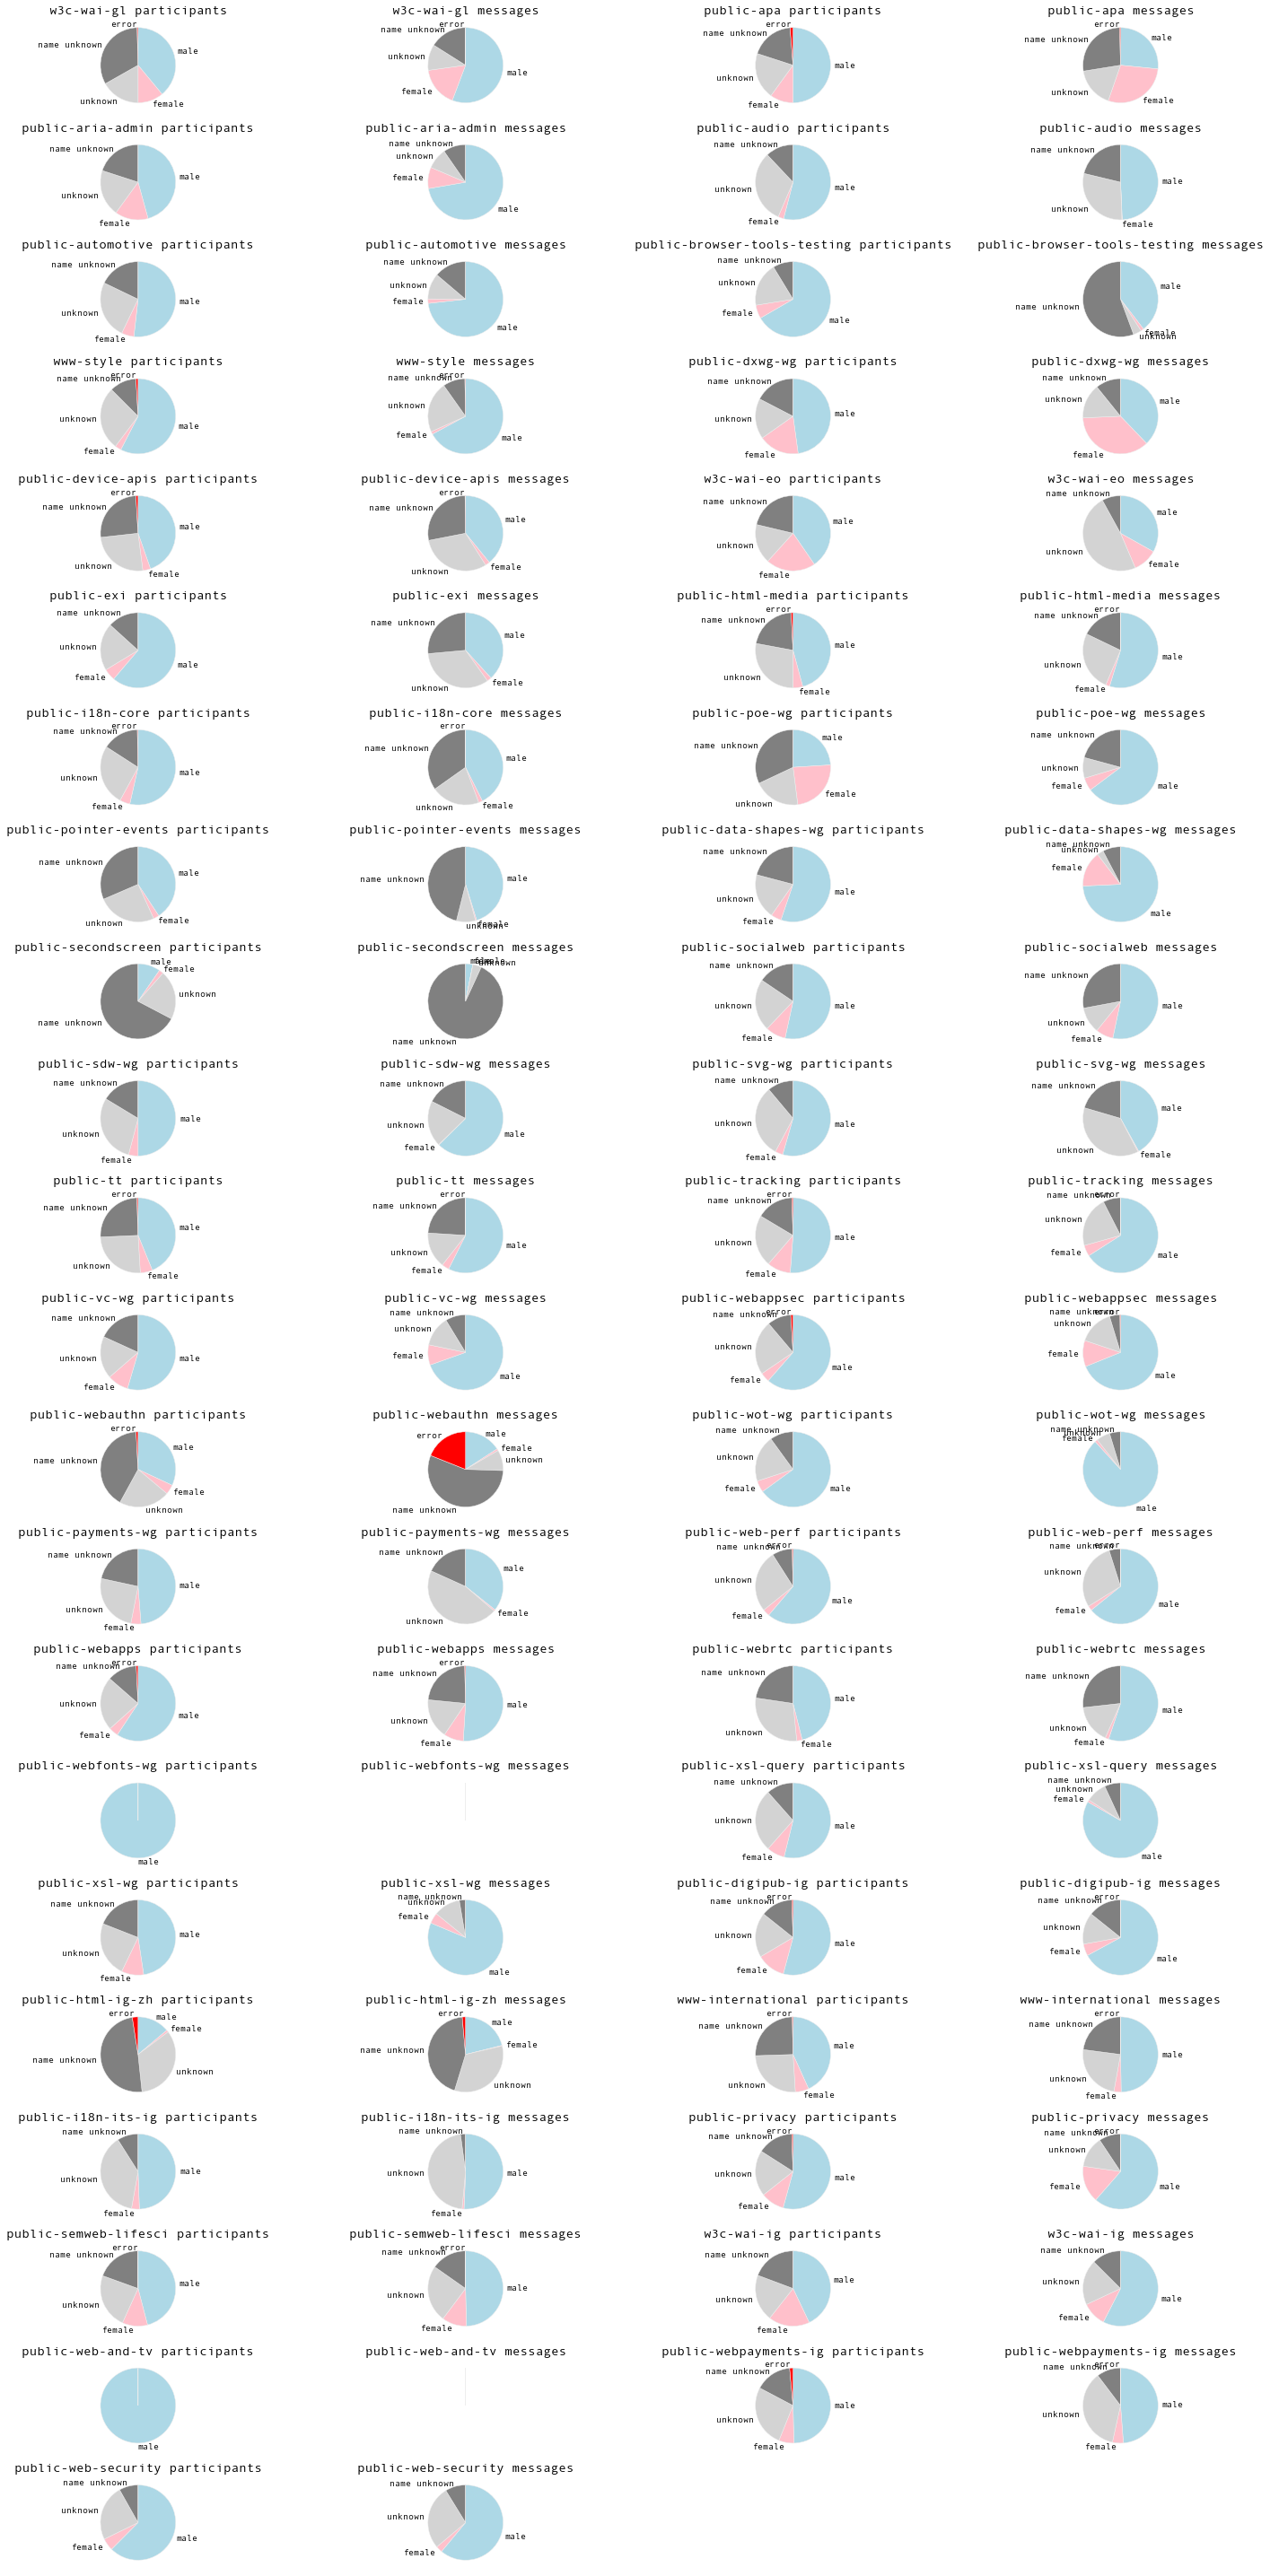

In [45]:
# define consistent colors for each label, using stereotypes, to be consistent across charts
def colors_for_labels(labels):
    qualitative_color_mapping = {'male':'lightblue', 'female':'pink', 'error':'red', 'unknown':'lightgray', 'name unknown':'gray'}
    return [qualitative_color_mapping[l] for l in labels]
gender_label_ordering = ['male','female','unknown','name unknown', 'error']

i = 1
cols = 4
rows = len(series)/2 + 1
fig = plt.figure(figsize=(20,40))

for ser in series:    
    ax = plt.subplot(rows, cols, i)
    participants = ser['participants']
    participants = participants.reindex(gender_label_ordering)
    participants.plot(kind='pie', colors=colors_for_labels(participants.index), startangle=90, counterclock=False)
    ax.set_aspect('equal')
    ax.set_title(ml_shortname(ser.name) + ' participants')
    ax.set_ylabel('')
    i+=1

    ax = plt.subplot(rows, cols, i)
    messages = ser['message count']
    messages = messages.reindex(gender_label_ordering)
    messages.plot(kind='pie', colors=colors_for_labels(messages.index), startangle=90, counterclock=False)
    ax.set_aspect('equal')
    ax.set_title(ml_shortname(ser.name) + ' messages')
    ax.set_ylabel('')
    i+=1
    
plt.tight_layout()
plt.savefig('gender-pies.png')